In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
sys.path.append('..')

import pandas as pd
from tqdm import tqdm
tqdm.pandas()

# Familirisation with data

In [3]:
data_path = "../data/jena_climate_2009_2016.csv"

In [4]:
data_df = pd.read_csv(data_path)

In [5]:
with open(data_path) as f:
    data = f.read()
    lines = data.split("\n")
    header = lines[0].split(",")
    lines = lines[1:]

In [6]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [7]:
print(lines[:5])

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30', '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10', '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60', '01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00', '01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30']


In [8]:
print(len(lines))

420451


## data -> numpy array

In [9]:
import numpy as np

In [10]:
float_data = np.zeros((len(lines), len(header) - 1))

In [11]:
print(float_data.shape)

(420451, 14)


In [12]:
for i, line in enumerate(lines):
    float_data[i] = line.split(",")[1:]

In [13]:
print(float_data.shape)

(420451, 14)


### Make data visualization

In [14]:
from kst.plots.BasePlots import BasePlots, ScatterPlot
from plotnine import *
from mizani.formatters import date_format

In [15]:
data_df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [16]:
data_df['Date Time'] = data_df['Date Time'].map(lambda x: pd.to_datetime(x, format='%d.%m.%Y %H:%M:%S'))

In [17]:
data_df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [18]:
sc = ScatterPlot(data_set=data_df.sample(frac=0.005),
                 aes = {'x':'Date Time', 'y':'T (degC)'},
                 main_title='Temperature over time',
                 x_label='Time',
                 y_label='T [C]',
                 legend_title='',
                 line = geom_line()
              )

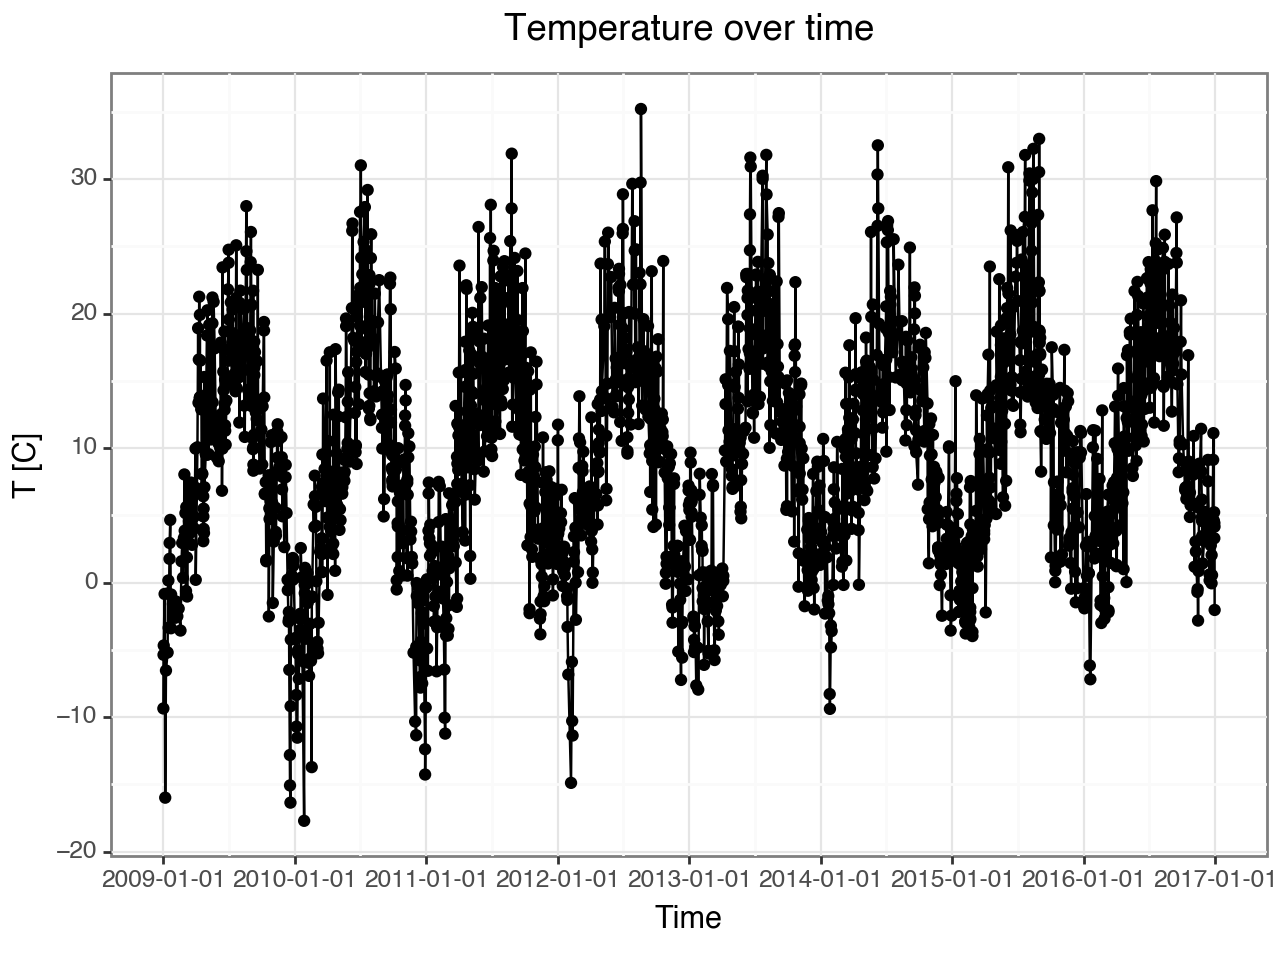

<Figure Size: (640 x 480)>

In [19]:
sc.plot + scale_x_datetime(labels = date_format("%Y-%m-%d"))

## data preprocessing

In [20]:
train_max_index, val_max_index = 200000, 300000

### scaling

In [21]:
mean_0 = float_data[:train_max_index].mean(axis = 0)
float_data -= mean_0
std_0 = float_data[:train_max_index].std(axis = 0)
float_data /= std_0

## data selection

In [22]:
lookback = int(5*24*60/10) # 5 days, 1 measuremnt per minute
delay = int(1*24*60/10)    # target is 1 day in the future
step = int(1*60/10)        # observations are smapled per an hour
batch_size = 128

In [23]:
def climate_generator(data,
                      lookback,
                      delay,
                      min_index,
                      max_index,
                      batch_size,
                      step,
                      shuffle = False):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(i, max_index, batch_size)
        else:
            if (i + batch_size) >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]

        yield samples, targets
                          

In [24]:
train_gen = climate_generator(data = float_data,
                  lookback = lookback,
                  delay = delay,
                  min_index = 0,
                  max_index = train_max_index,
                  batch_size = batch_size,
                  step = step,
                  shuffle = True)

val_gen = climate_generator(data = float_data,
                  lookback = lookback,
                  delay = delay,
                  min_index = train_max_index + 1,
                  max_index = val_max_index,
                  batch_size = batch_size,
                  step = step,
                  shuffle = True)

test_gen = climate_generator(data = float_data,
                  lookback = lookback,
                  delay = delay,
                  min_index = val_max_index + 1,
                  max_index = None,
                  batch_size = batch_size,
                  step = step,
                  shuffle = False)

In [25]:
val_steps = val_max_index - train_max_index - 1 - lookback
test_steps = len(float_data) - val_max_index - 1 - lookback

In [26]:
print("val_gen stapes {}".format(val_steps))
print("test_steps stapes {}".format(test_steps))

val_gen stapes 99279
test_steps stapes 119730


# Modeling

In [27]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

2023-08-24 23:26:35.922872: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
model = Sequential()
model.add(layers.Flatten(input_shape = (lookback//step,float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1680)              0         
                                                                 
 dense (Dense)               (None, 32)                53792     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 53,825
Trainable params: 53,825
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(optimizer=RMSprop(), loss='mae')

In [31]:
fit_history = model.fit_generator(train_gen,
                                  steps_per_epoch=500,
                                  epochs=20,
                                  validation_data=val_gen,
                                  validation_steps=500
                                  )

Epoch 1/20


/var/folders/73/1_fd1jr14477j2fv2b70mpx00000gn/T/ipykernel_3275/4168167623.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
2023-08-24 23:26:42.334668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


492/500 [============================>.] - ETA: 0s - loss: 0.6857

2023-08-24 23:26:45.375601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - 5s 10ms/step - loss: 0.6811 - val_loss: 0.4414
Epoch 2/20
500/500 [==============================] - 5s 10ms/step - loss: 0.3310 - val_loss: 0.3806
Epoch 3/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2846 - val_loss: 0.3314
Epoch 4/20
500/500 [==============================] - 5s 9ms/step - loss: 0.2680 - val_loss: 0.3032
Epoch 5/20
500/500 [==============================] - 5s 9ms/step - loss: 0.2592 - val_loss: 0.3160
Epoch 6/20
500/500 [==============================] - 5s 9ms/step - loss: 0.2530 - val_loss: 0.2931
Epoch 7/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2480 - val_loss: 0.3040
Epoch 8/20
500/500 [==============================] - 5s 9ms/step - loss: 0.2450 - val_loss: 0.3062
Epoch 9/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2401 - val_loss: 0.2935
Epoch 10/20
500/500 [==============================] - 5s 9ms/step - loss: 0.2374 - val_loss: 0.2936
Epoch

In [32]:
df = pd.DataFrame.from_dict(fit_history.history)
df['epoch'] = df.index.to_list()
df

,loss,val_loss,epoch
0,0.681141,0.441427,0
1,0.331019,0.380618,1
2,0.284648,0.331406,2
3,0.267992,0.303180,3
4,0.259223,0.315980,4
5,0.253012,0.293144,5
6,0.247989,0.303986,6
7,0.244957,0.306150,7
8,0.240147,0.293496,8
9,0.237377,0.293550,9


In [33]:
sc = ScatterPlot(data_set=df,
                 aes = {'x':'epoch', 'y':'loss', 'color':"'training'"},
                 main_title='Mean Absolute Error',
                 x_label='Epoch',
                 y_label='Loss',
                 legend_title='',
                 line = geom_line()
              )

sc.add_gg_object(geom_point(df, aes(x = 'epoch', y = 'val_loss', color = "'validation'")))
sc.add_gg_object(geom_line(df, aes(x = 'epoch', y = 'val_loss', color = "'validation'")))

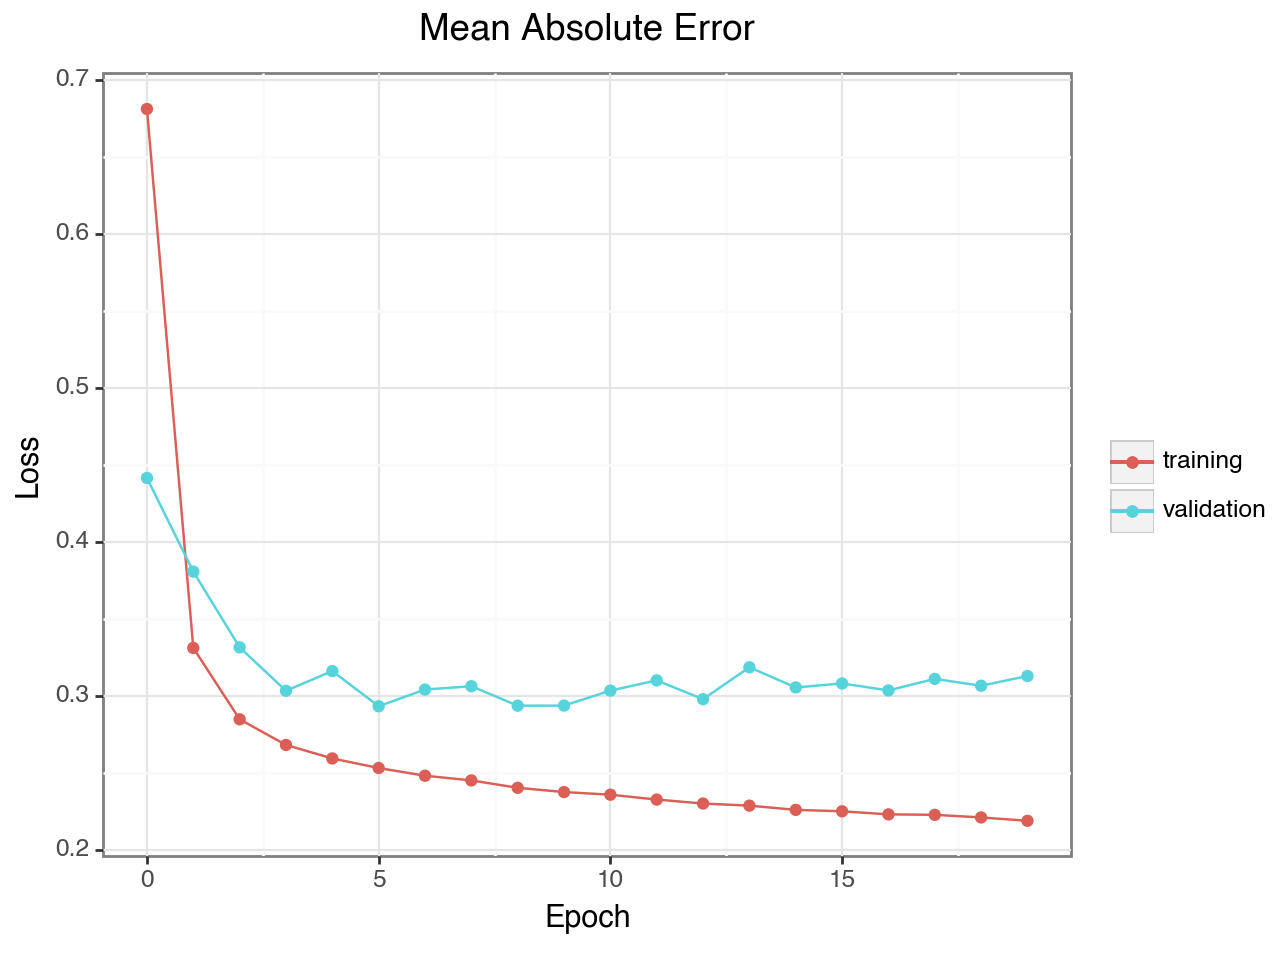

<Figure Size: (640 x 480)>

In [34]:
sc.plot

In [35]:
model_gru = Sequential()
model_gru.add(layers.Conv1D(16, 3, activation = 'relu', input_shape=(None,float_data.shape[-1])))
model_gru.add(layers.GRU(32,
                         dropout=0.1,
                         recurrent_dropout=0.1
                        )
             )
model_gru.add(layers.Dense(16, activation='relu'))
model_gru.add(layers.Dropout(0.2))
model_gru.add(layers.Dense(1))

In [36]:
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          688       
                                                                 
 gru (GRU)                   (None, 32)                4800      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,033
Trainable params: 6,033
Non-trainable params: 0
_________________________________________________________________


In [37]:
model_gru.compile(optimizer=RMSprop(learning_rate=0.001, momentum = 0.3),loss='mae')

In [38]:
fit_history = model_gru.fit_generator(train_gen,
                                  steps_per_epoch=500,
                                  epochs=20,
                                  validation_data=val_gen,
                                  validation_steps=1000
                                  )

Epoch 1/20


/var/folders/73/1_fd1jr14477j2fv2b70mpx00000gn/T/ipykernel_3275/1566544207.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
2023-08-24 23:28:21.058972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - ETA: 0s - loss: 0.3652

2023-08-24 23:29:02.430483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - 62s 120ms/step - loss: 0.3652 - val_loss: 0.2845
Epoch 2/20
500/500 [==============================] - 50s 100ms/step - loss: 0.3329 - val_loss: 0.2757
Epoch 3/20
500/500 [==============================] - 49s 98ms/step - loss: 0.3232 - val_loss: 0.2700
Epoch 4/20
500/500 [==============================] - 50s 99ms/step - loss: 0.3145 - val_loss: 0.2633
Epoch 5/20
500/500 [==============================] - 50s 100ms/step - loss: 0.3085 - val_loss: 0.2674
Epoch 6/20
500/500 [==============================] - 48s 96ms/step - loss: 0.3061 - val_loss: 0.2628
Epoch 7/20
500/500 [==============================] - 47s 95ms/step - loss: 0.3001 - val_loss: 0.2774
Epoch 8/20
500/500 [==============================] - 47s 95ms/step - loss: 0.2981 - val_loss: 0.2610
Epoch 9/20
500/500 [==============================] - 47s 95ms/step - loss: 0.2949 - val_loss: 0.2680
Epoch 10/20
500/500 [==============================] - 49s 98ms/step - loss: 0.2906 - val_

In [39]:
df = pd.DataFrame.from_dict(fit_history.history)
df['epoch'] = df.index.to_list()
df

,loss,val_loss,epoch
0,0.365235,0.284488,0
1,0.332890,0.275694,1
2,0.323225,0.269987,2
3,0.314453,0.263294,3
4,0.308475,0.267354,4
5,0.306067,0.262829,5
6,0.300143,0.277391,6
7,0.298144,0.260961,7
8,0.294859,0.267977,8
9,0.290573,0.265460,9


In [40]:
sc = ScatterPlot(data_set=df,
                 aes = {'x':'epoch', 'y':'loss', 'color':"'training'"},
                 main_title='Mean Absolute Error',
                 x_label='Epoch',
                 y_label='Loss',
                 legend_title='',
                 line = geom_line()
              )

sc.add_gg_object(geom_point(df, aes(x = 'epoch', y = 'val_loss', color = "'validation'")))
sc.add_gg_object(geom_line(df, aes(x = 'epoch', y = 'val_loss', color = "'validation'")))

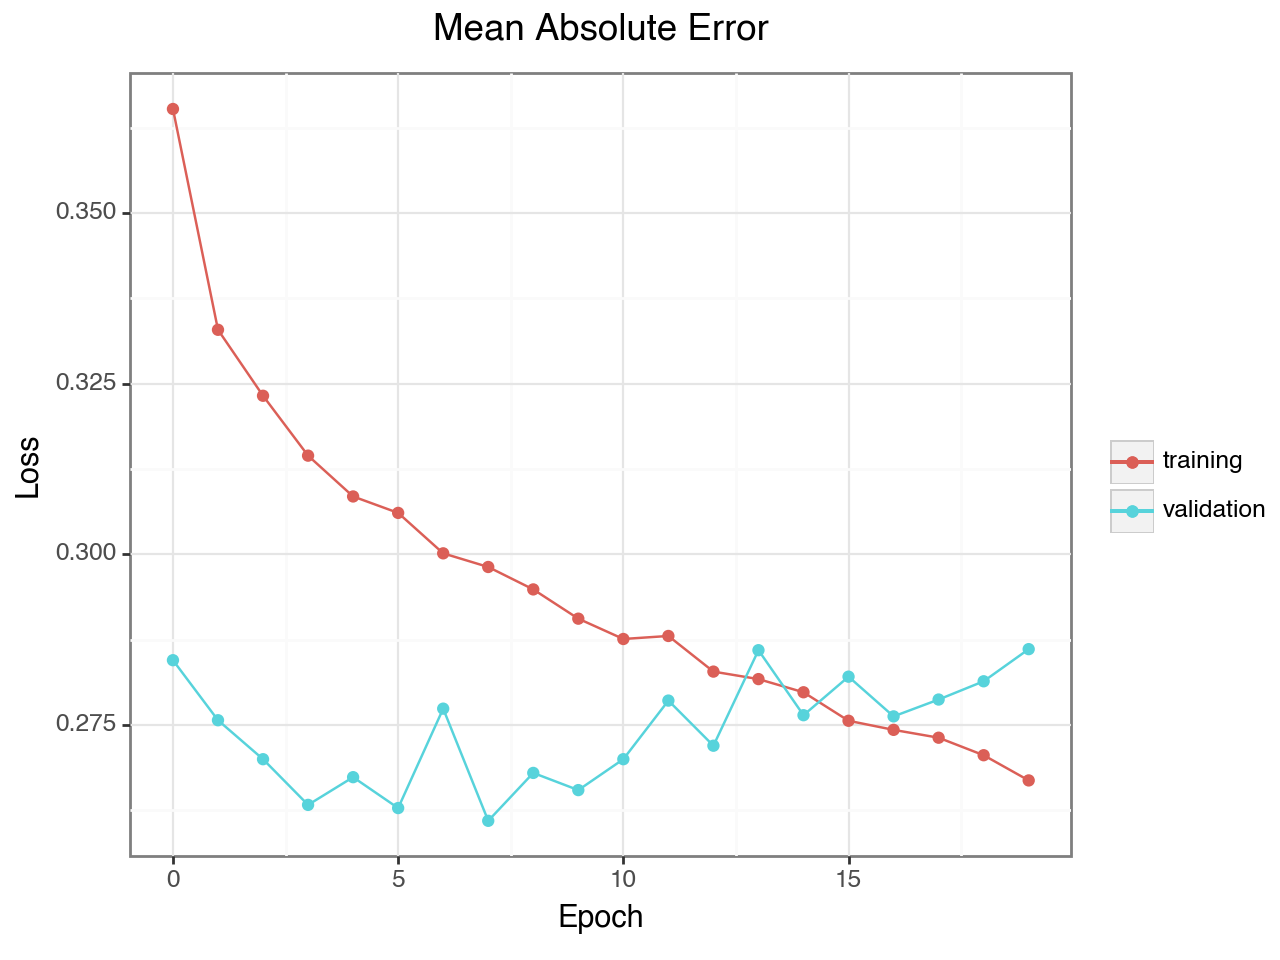

<Figure Size: (640 x 480)>

In [41]:
sc.plot

In [42]:
test_results = pd.DataFrame()

for i in range(100):
    x, y = next(test_gen)
    predictions = model_gru.predict(x)
    test_results = pd.concat([test_results, pd.DataFrame.from_dict({'real_temp':y, 'predicted_temp':predictions.reshape(-1)})], ignore_index=True)

4/4 [==============================] - 0s 14ms/step


In [43]:
test_results.reset_index(inplace=True)
test_results.rename(columns={'index':'number'},inplace=True)

In [44]:
test_results.real_temp /= std_0[1]
test_results.real_temp += mean_0[1]
test_results.predicted_temp /= std_0[1]
test_results.predicted_temp += mean_0[1]

In [45]:
sc = ScatterPlot(data_set=test_results,
                 aes = {'x':'number', 'y':'real_temp', 'color':"'measurement'"},
                 main_title='Test',
                 x_label='Epoch',
                 y_label='Loss',
                 legend_title='',
                 line = geom_line()
              )

sc.add_gg_object(geom_point(test_results, aes(x = 'number', y = 'predicted_temp', color = "'prediction'")))
sc.add_gg_object(geom_line(test_results, aes(x = 'number', y = 'predicted_temp', color = "'prediction'")))

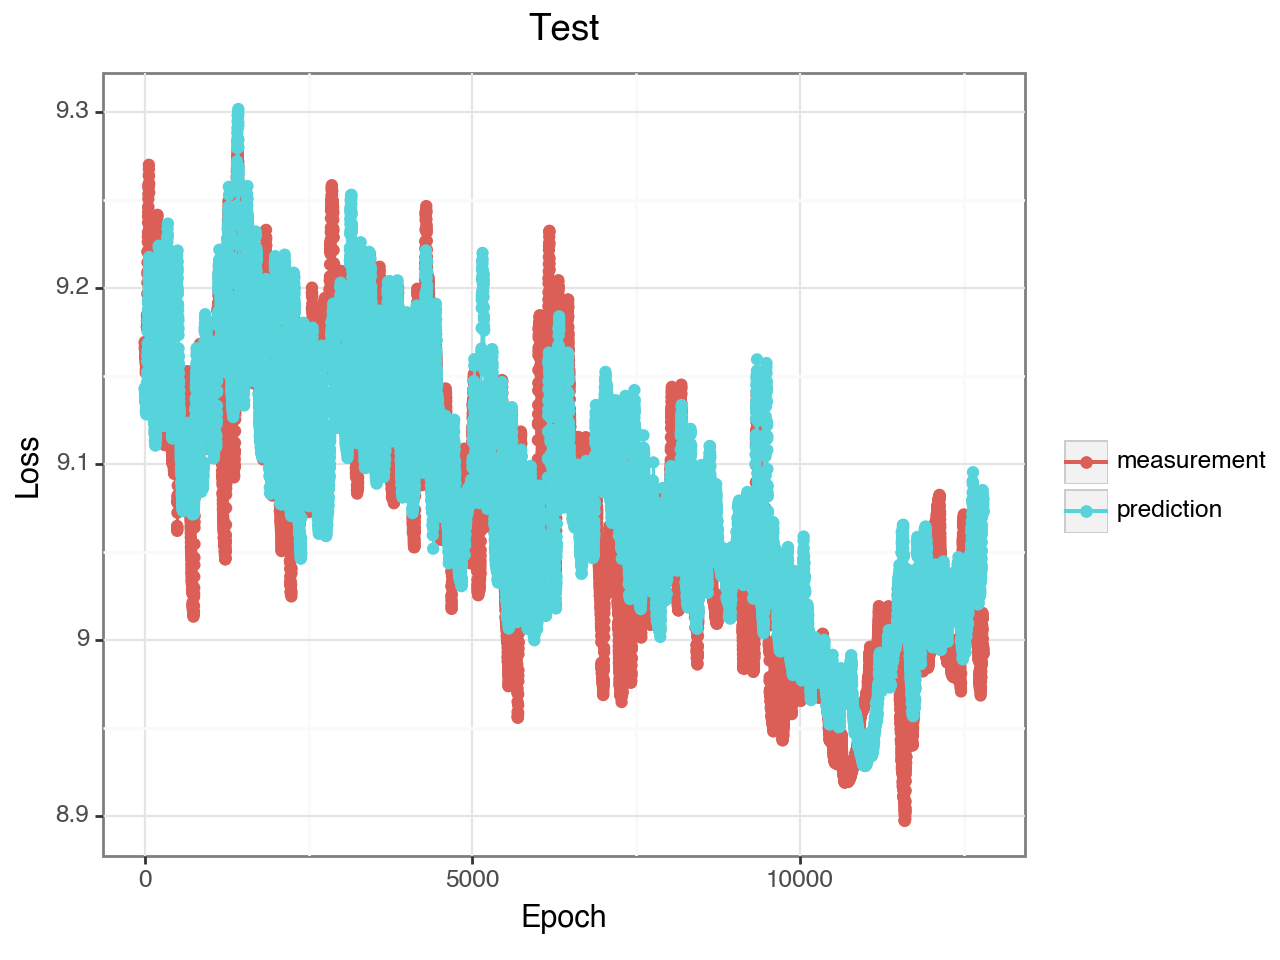

<Figure Size: (640 x 480)>

In [46]:
sc.plot